In [1]:
import pandas as pd
import numpy as np
import gensim
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.initializers import Constant
from sklearn.preprocessing import OneHotEncoder


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path=None
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    return ax

In [3]:
news_stocks = pd.read_csv("dataset/news_stocks.csv")

In [4]:
def all_vec_words(row):
    words = row["All_news"].split()
    vec_list = []
    for word in words:
        if word in word2vec_model:
            vec_list.append(word2vec_model[word])   
    return vec_list

def avg_vec_words(row):
    vec_list = all_vec_words(row)
    avg_vec = sum(vec_list) / len(vec_list)
    return avg_vec

In [5]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)  

In [6]:
news_stocks["all_vec"] = news_stocks.apply(all_vec_words, axis=1)

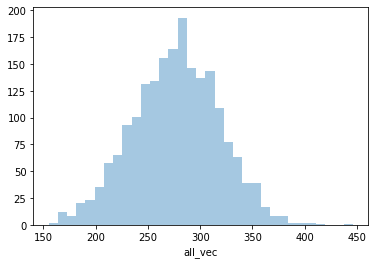

In [7]:
# Plot length of word vectors for each day
sns.distplot(news_stocks["all_vec"].str.len(), kde=False)

In [8]:
word_vectors_len = 350

In [9]:
train = news_stocks[news_stocks['Date'] < '2015-01-01']
test = news_stocks[news_stocks['Date'] > '2014-12-31']

In [10]:
x_train = train["all_vec"]
y_train = train["Label"]
x_test = test["all_vec"]
y_test = test["Label"]

In [11]:
x_train = pad_sequences(x_train, 
                        maxlen=word_vectors_len,
                        dtype="float32"
                       )
x_test = pad_sequences(x_test, 
                       maxlen=word_vectors_len,
                       dtype="float32"
                      )

In [12]:
perm = np.random.permutation(len(x_train))
x_train = x_train[perm]
y_train = y_train[perm]

In [13]:
print("Train data: %d records" % len(x_train))
print("Test data: %d records" % len(x_test))

Train data: 1611 records
Test data: 378 records


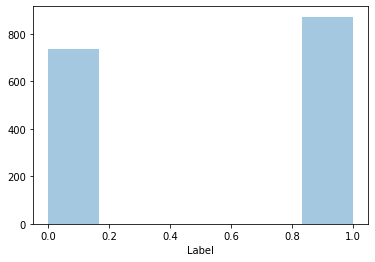

In [14]:
sns.distplot(y_train, kde=False)

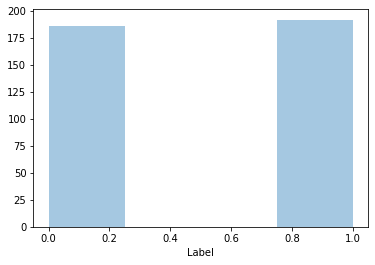

In [15]:
sns.distplot(y_test, kde=False)

### Model

In [16]:
softmax = False

In [17]:
if softmax:
    # 0 => [1,0], 1=> [0,1]
    encode = {
        0: [1,0],
        1: [0,1]
    }
    y_train = np.asarray([encode[y] for y in y_train])

In [18]:
model = Sequential()
model.add(Conv1D(filters=32, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu', 
                 strides=1,
                 input_shape=(350, 300)
                )
         )
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(LSTM(8, 
               dropout=0.4, 
               recurrent_dropout=0.2,
                )
#                         , input_shape=(350, 300)
         )
         
# model.add(Dropout(0.4))
if softmax:
    model.add(Dense(2, activation='softmax'))
else:
    model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

W0717 16:10:43.992817 140362994587456 deprecation.py:506] From /home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 16:10:44.382611 140362994587456 deprecation.py:323] From /home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 349, 32)           19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 174, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 174, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 20,553
Trainable params: 20,553
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train,
                    y_train, 
                    batch_size=32, 
                    epochs=5, 
                    validation_split=0.2
                    )

Train on 1288 samples, validate on 323 samples
Epoch 1/5
1288/1288 [==============================] - 17s 13ms/sample - loss: 0.6882 - acc: 0.5435 - val_loss: 0.6987 - val_acc: 0.5170
Epoch 2/5
1288/1288 [==============================] - 16s 12ms/sample - loss: 0.6850 - acc: 0.5489 - val_loss: 0.6976 - val_acc: 0.5170
Epoch 3/5
1288/1288 [==============================] - 15s 12ms/sample - loss: 0.6856 - acc: 0.5497 - val_loss: 0.6971 - val_acc: 0.5170
Epoch 4/5
1288/1288 [==============================] - 15s 12ms/sample - loss: 0.6784 - acc: 0.5730 - val_loss: 0.6966 - val_acc: 0.5170
Epoch 5/5
1288/1288 [==============================] - 16s 12ms/sample - loss: 0.6703 - acc: 0.5815 - val_loss: 0.6951 - val_acc: 0.5263


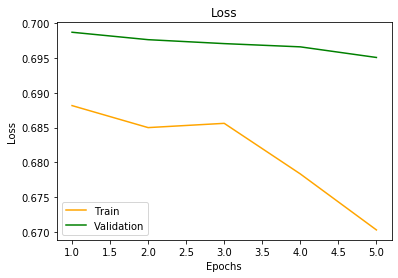

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./figures/CNN_LSTM_loss_5epochs_sigmoid.png', 
            dpi=300)

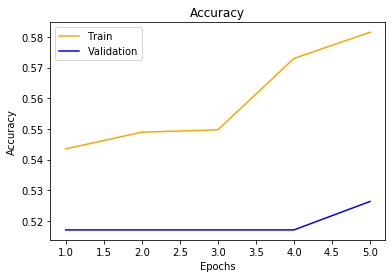

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./figures/CNN_LSTM_Accuracy_5epochs_sigmoid.png', 
            dpi=300)

In [106]:
model.save("./models/CNN_LSTM_5epochs_sigmoid.h5")

In [107]:
y_predict = model.predict(x_test)

In [108]:
y_predict[0:5]

array([[0.5646927 ],
       [0.5128962 ],
       [0.4938347 ],
       [0.5308018 ],
       [0.59712064]], dtype=float32)

In [109]:
if softmax:
    def decode(y):
        return 0 if y[0] > y[1] else 1
    y_predict = list(map(decode, y_predict))
else:
    def decode(y):
        return 0 if y < 0.5 else 1
    y_predict = list(map(decode, y_predict))    

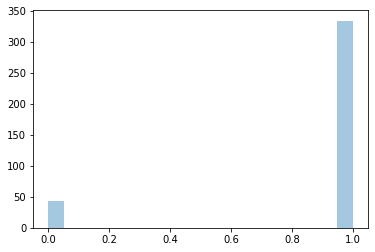

In [110]:
sns.distplot(y_predict, kde=False)

In [111]:
print(accuracy_score(y_test, y_predict))
print(f1_score(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

0.5079365079365079
0.6463878326996197
[[ 22 164]
 [ 22 170]]


Confusion matrix, without normalization
[[ 22 164]
 [ 22 170]]


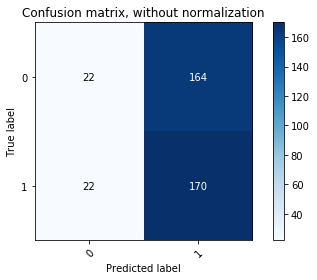

In [112]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_predict, 
                      classes=np.asarray(['0', '1']),
                      title='Confusion matrix, without normalization',
                      save_path='./figures/CNN_LSTM_5epochs_sigmoid_confusion.png'
                     )

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')